# Support Vector Machine Algorithm

In [1]:
# Importing Libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Loading train and test datasets

#### Test dataset

In [14]:
test_data = pd.read_csv('./data/SalaryData_Test.csv')
print(test_data.head(10))

   age          workclass      education  educationno        maritalstatus  \
0   25            Private           11th            7        Never-married   
1   38            Private        HS-grad            9   Married-civ-spouse   
2   28          Local-gov     Assoc-acdm           12   Married-civ-spouse   
3   44            Private   Some-college           10   Married-civ-spouse   
4   34            Private           10th            6        Never-married   
5   63   Self-emp-not-inc    Prof-school           15   Married-civ-spouse   
6   24            Private   Some-college           10        Never-married   
7   55            Private        7th-8th            4   Married-civ-spouse   
8   65            Private        HS-grad            9   Married-civ-spouse   
9   36        Federal-gov      Bachelors           13   Married-civ-spouse   

           occupation    relationship    race      sex  capitalgain  \
0   Machine-op-inspct       Own-child   Black     Male            0   

#### Train dataset

In [13]:
train_data = pd.read_csv('./data/SalaryData_Train.csv')
print(train_data.head(10))

   age          workclass   education  educationno           maritalstatus  \
0   39          State-gov   Bachelors           13           Never-married   
1   50   Self-emp-not-inc   Bachelors           13      Married-civ-spouse   
2   38            Private     HS-grad            9                Divorced   
3   53            Private        11th            7      Married-civ-spouse   
4   28            Private   Bachelors           13      Married-civ-spouse   
5   37            Private     Masters           14      Married-civ-spouse   
6   49            Private         9th            5   Married-spouse-absent   
7   52   Self-emp-not-inc     HS-grad            9      Married-civ-spouse   
8   31            Private     Masters           14           Never-married   
9   42            Private   Bachelors           13      Married-civ-spouse   

           occupation    relationship    race      sex  capitalgain  \
0        Adm-clerical   Not-in-family   White     Male         2174   

## Data understanding

### Dataset size

In [15]:
print(
    f"Test dataset size: {test_data.shape[0]}\n"
    f"Train dataset size: {train_data.shape[0]}"
    )

Test dataset size: 15060
Train dataset size: 30161


In [16]:
print(train_data.describe())
print(train_data.info())

                age   educationno   capitalgain   capitalloss  hoursperweek
count  30161.000000  30161.000000  30161.000000  30161.000000  30161.000000
mean      38.438115     10.121316   1092.044064     88.302311     40.931269
std       13.134830      2.550037   7406.466611    404.121321     11.980182
min       17.000000      1.000000      0.000000      0.000000      1.000000
25%       28.000000      9.000000      0.000000      0.000000     40.000000
50%       37.000000     10.000000      0.000000      0.000000     40.000000
75%       47.000000     13.000000      0.000000      0.000000     45.000000
max       90.000000     16.000000  99999.000000   4356.000000     99.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null 

### Data Description

| Term          | Definition                                                                       |
|---------------|----------------------------------------------------------------------------------|
| Education     | Highest level of education                                                       |
| workclass     | Which business sector a person works for                                         |
| educationno   | Years spent in school?                                                           |
| maritalstatus | Relationship status                                                              |
| occupation    | Current occupation                                                               |
| relationship  | If they have a spouse or child                                                   |
| race          | A social construct to group people                                               |
| sex           | Gender                                                                           |
| capitalgain   | Profit gained from the sale of property or investment                            |
| capitalloss   | Value lost from the seller when selling property or investment at a lower cost   |
| hourseperweek | Hours worked per week                                                            |
| native        | A person's country of citizenship                                                |
| Salary        | Category on whether a person makes less than or greater than or equal to $50,000 |

## Data Visualization

### Data Scatterplot

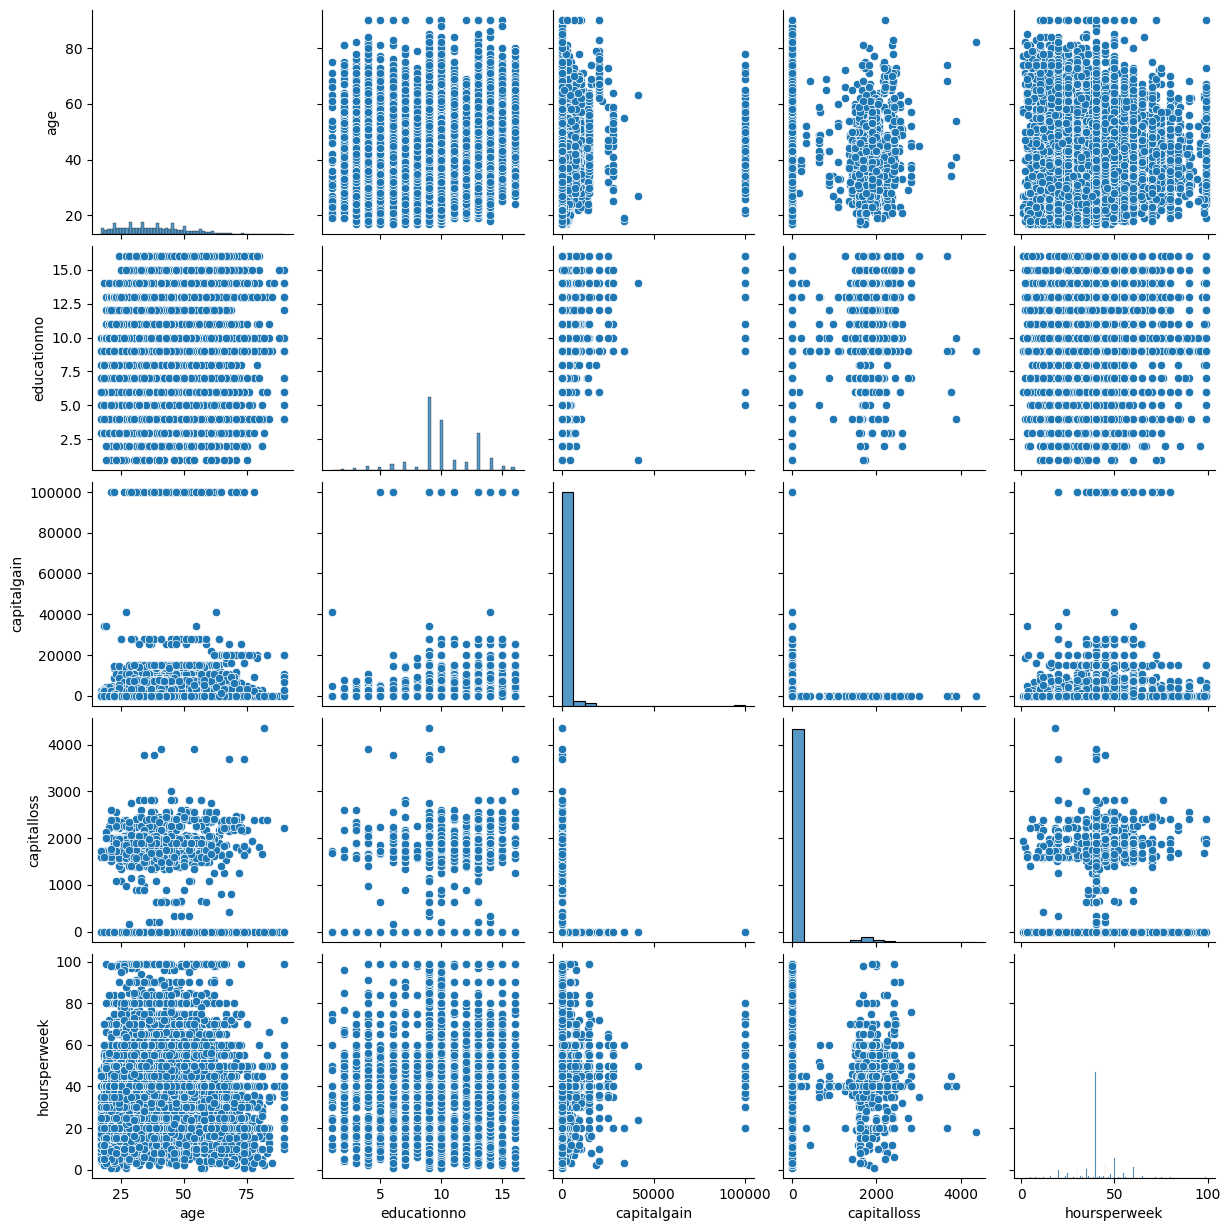

In [17]:
sns.pairplot(train_data)

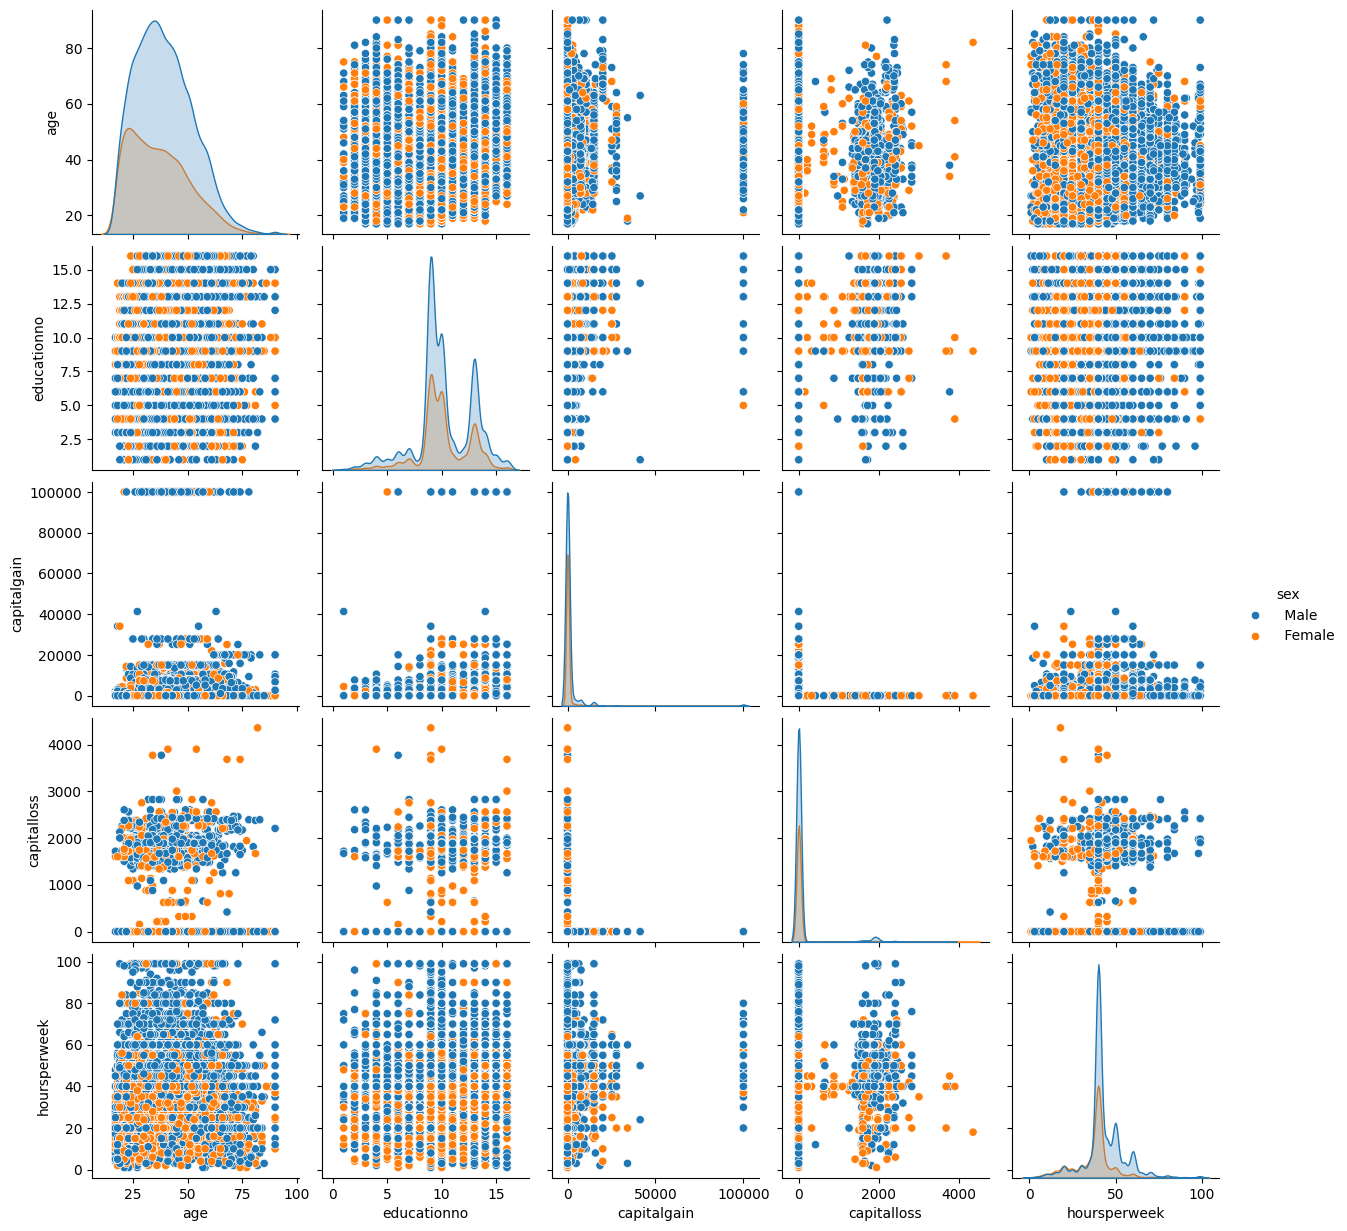

In [18]:
sns.pairplot(train_data, hue='sex')

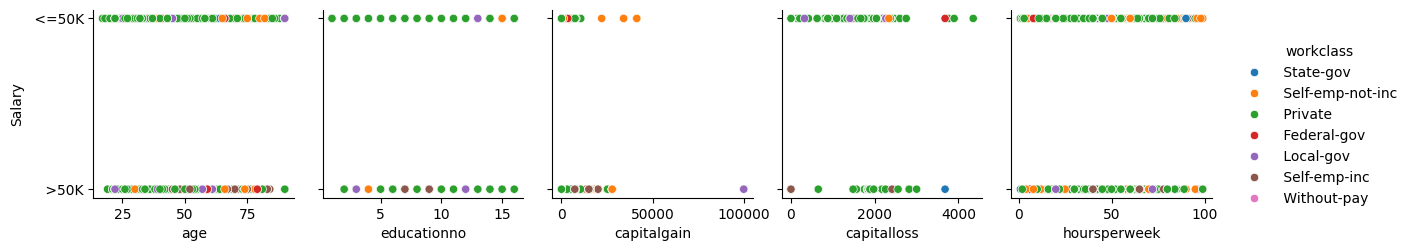

In [19]:
sns.pairplot(train_data, hue='workclass', y_vars=['Salary'])

## Data Processing

### Label Encoder

In order for a model to work with the data provided, especially strings, the data must be categorized with discrete values.

Setting `train_data` columns with `object` values into enumerated integers. 

In [4]:
le = LabelEncoder()
train_data['Salary'] = le.fit_transform(train_data['Salary'])
train_data['workclass'] = le.fit_transform(train_data['workclass'])
train_data['education'] = le.fit_transform(train_data['education'])
train_data['maritalstatus'] = le.fit_transform(train_data['maritalstatus'])
train_data['occupation'] = le.fit_transform(train_data['occupation'])
train_data['relationship'] = le.fit_transform(train_data['relationship'])
train_data['race'] = le.fit_transform(train_data['race'])
train_data['sex'] = le.fit_transform(train_data['sex'])
train_data['native'] = le.fit_transform(train_data['native'])



## Model Building

### Preparing the train and test values

In [5]:
x_train = train_data
y_train = train_data['Salary']
x_test = test_data
y_test = test_data['Salary']

# Perform label encoding
x_test['education'] = le.fit_transform(x_test['education'])
x_test['relationship'] = le.fit_transform(x_test['relationship'])
y_test = le.fit_transform(y_test)

print(f"x_train shape: {x_train.shape}\n"
      f"y_train shape: {y_train.shape}\n"
      f"x_test shape: {x_test.shape}\n"
      f"y_test shape: {y_test.shape}")

x_train shape: (30161, 14)
y_train shape: (30161,)
x_test shape: (15060, 14)
y_test shape: (15060,)


### Factors that I believe affect salary the most

I've chosen the following factors that affect salary the most:
- Education
  - A person's level of education gives the access to higher paying opportunities.
- Relationship
  - Dependents may or may not affect a person's ability to work more

In [6]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

x_train = x_train[['education', 'relationship']].copy()
x_test = x_test[['education', 'relationship']].copy()

### Training the data

Training with polynomial kernel causes the whole program to freeze

In [7]:
for kernel in ("linear", "rbf"):
    clf = svm.SVC(kernel=kernel, gamma=2)
    clf.fit(x_train, y_train)

    print(
        f"Accuracy of kernel {kernel}: {accuracy_score(y_test, clf.predict(x_test)) * 100:.2f}%"
    )

Accuracy of kernel linear: 75.43%
Accuracy of kernel rbf: 81.59%


### Plotting model boundary

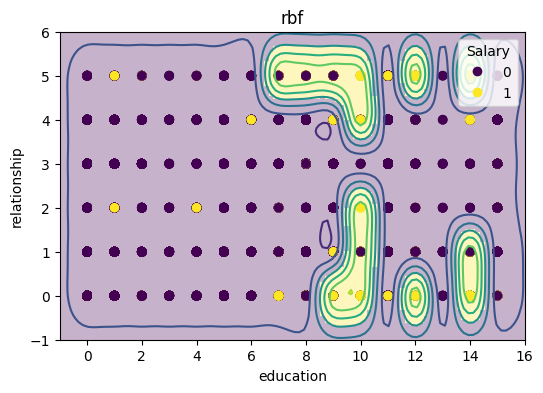

In [12]:
x_min, x_max = train_data['education'].min() - 1, train_data['education'].max() + 1
y_min, y_max = train_data['relationship'].min() - 1, train_data['relationship'].max() + 1
    
fig, ax = plt.subplots(figsize=(6,4))
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

common_params = {
    "estimator": clf,
    "X": x_train,
    "ax": ax
}

DecisionBoundaryDisplay.from_estimator(**common_params, 
                                        response_method="predict", 
                                        plot_method='pcolormesh',
                                        alpha=0.3)
DecisionBoundaryDisplay.from_estimator(**common_params,
                                        response_method="decision_function",
                                        plot_method="contour",
                                        )
scatter = ax.scatter(
    train_data['education'], train_data['relationship'], c=y_train
)
ax.legend(*scatter.legend_elements(), loc="upper right", title="Salary")
ax.set_title(kernel)
plt.show()
